# Correction of the wavelength dependent pixel drift  - SWIR
**Abstract** --  *This document gives an analysis of the observed wavelength dependent pixel drift, and shows a way correction methed. This correction method is then analysed.*

The document is made in Jupyter Notebook with MATLAB 2019b

(note - this script is run in linux, in windows '/' might need to be changed to '\\')

In [1]:
format compact
%plot inline
addpath(genpath(pwd))

% this box is just for some settings. inline vs native2unicode

## Analysing the pixel drift
The pixel drift can be observed by looking at the image in different wavelengts. For the SWIR is visible here
![SegmentLocal](images/Sample_2_pixel.gif "segment")
This movement is bad when the samples move because it creates a spectal frankenstein from all pixels on the path

### Estimeating the pixel drift with a checker board
Method: use a black and white checkerboard that black and white in all used wavelengths. The take one reference chanel and see what vector should be added to $x$ and $y$ coordinate in order to restore the shape. This obviously reaquires a continous value from the vecter which can be done in matlab using `interp2()`.

$$ \text{HSI_corrected}(i,j,\lambda) =  \text{HSI}(i+\delta_i(\lambda),j+\delta_j(\lambda),\lambda) $$

For better statistics I used a couple of measurements for each camera. First, select the files by there name. There were 6 samples made with the a side of 0.25 $cm$ and 6 samples with a side of 0.5 $cm$. Always 3 straight and 3 at an angle. 

In [2]:
do_calculation = true;
do_calculation = false  % calculation may take a while, comment this line to do calculation

if do_calculation
    for interp_method = ["linear","cubic"]
        interp_method
        tic
        total_path = './metingen/project pixelmovement/SWIR/SWIR_BW_*_corrected.raw';
        names = find_files(total_path);
        [~,n] = size(names);
        all_paths = {};
        for i = 1:n
%             i
           r = HSI_pathfinder(names{i}, 50, interp_method, 5);
           all_paths{end+1} = r;
        end
        toc
        if interp_method == "linear"
            save all_paths_SWIR_linear.mat all_paths
        else
            save all_paths_SWIR_cubic.mat all_paths         
        end
    end
else
    load all_paths_SWIR_linear.mat
    load all_paths_SWIR_cubic.mat
end

do_calculation =
  logical
   0


In time we have
 * Linear: 353 seconds
 * Cubic:  417 seconds

All paths plotted gives

interp_method = 
    "linear"
maximum_deviation =
    0.0221
interp_method = 
    "cubic"
maximum_deviation =
    0.0223


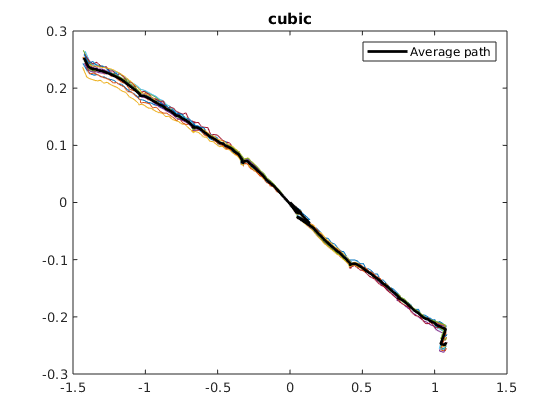

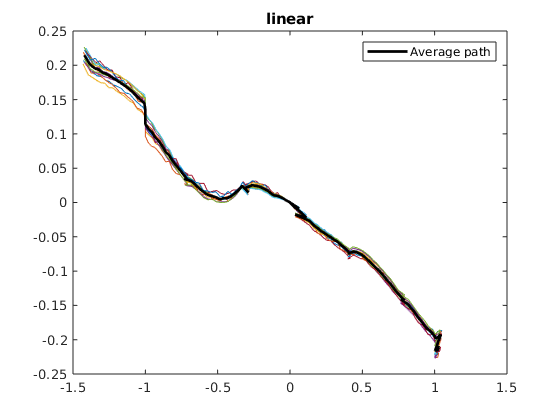

In [4]:
for interp_method = ["linear","cubic"]
    if interp_method == "linear"
        load all_paths_SWIR_linear.mat
    else
        load all_paths_SWIR_cubic.mat
    end
    
    [~,n] = size(all_paths);
    average_path = zeros(size(all_paths{1}));
    figure
    for i = 1:n
        r = all_paths{i};
        plot(r(1,:),r(2,:),'HandleVisibility','off')
        hold on
        average_path = average_path +r;
    end
    average_path =  average_path/n;
    plot(average_path(1,:),average_path(2,:),'k','linewidth',2)
    [~, nb] = size(average_path);
    legend('Average path')
    title(interp_method)
    maximum_deviation = 0;
    for i = 1:n
        r = all_paths{i};
        deviation = r-average_path;
        for j = 1:nb
            if norm(deviation(:,j)) > maximum_deviation
                maximum_deviation = norm(deviation(:,j));
            end
        end
    end
    interp_method
    maximum_deviation
    
    if interp_method == "linear"
        save average_path_SWIR_linear average_path
    else
        save average_path_SWIR_cubic average_path
    end 
end


% viscircles(average_path',maximum_deviation*ones(nb,1)) % run this if you want to check
% (requires image processing toolbox)



The thick line is the average path. The maximum devation frome this path for all lines is  about 0.022 pixels (uncomment the last line if you want to dubble check it). This suggest the average is a reasonable pixelpath; we'll save the path.

Visualy this means

length_path_pixel =
    2.4860
length_path_cm =
    0.0845
length_path_pixel =
    2.5530
length_path_cm =
    0.0868


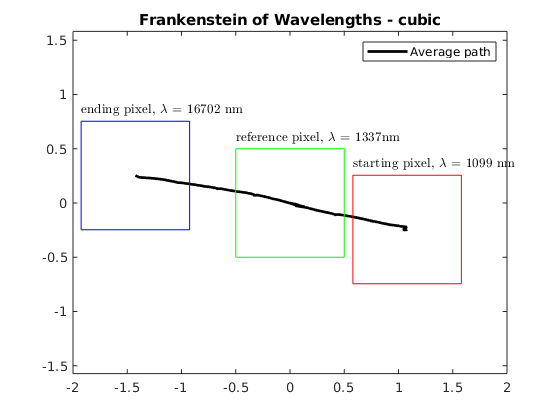

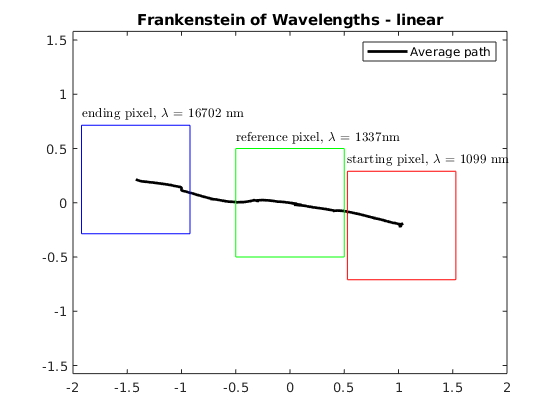

In [5]:
for interp_method = ["linear","cubic"]
    if interp_method == "linear"
        load average_path_SWIR_linear.mat
    else
        load average_path_SWIR_cubic.mat
    end
    figure
    plot(average_path(1,:),average_path(2,:),'k','linewidth',2)
    [~, nb] = size(average_path);
    title("Frankenstein of Wavelengths - " + interp_method), axis([-2,2,-1.5, 1.5])
    legend('Average path')
    axis equal, hold on

    draw_pixel(0,0,'g')
    text(-.5,.6,'reference pixel, $\lambda$  = 1337nm','interpreter', 'latex')

    draw_pixel(average_path(1,1),average_path(2,1),'r')
    text(average_path(1,1)-.5,average_path(2,1) + .6,'starting pixel, $\lambda$  = 1099 nm','interpreter', 'latex')

    draw_pixel(average_path(1,end),average_path(2,end),'b')
    text(average_path(1,end)-.5,average_path(2,end) + .6,'ending pixel, $\lambda$  = 16702 nm','interpreter', 'latex')
    length_path_pixel = norm(average_path(:,1)-average_path(:,end))
length_path_cm = length_path_pixel *  0.0340
end

In [6]:
length_path_pixel = norm(average_path(:,1)-average_path(:,end))
length_path_cm = length_path_pixel *  0.0340

length_path_pixel =
    2.5530
length_path_cm =
    0.0868


To total distance traveled is short of a milimeter.

### Correcting the pixeldrift
I wrote a code which tries to correct this pixel drift by interpolationg from the right pixels, taking the motion into account.

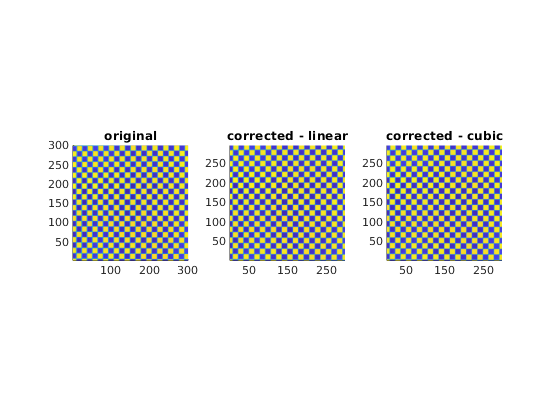

In [7]:
%plot inline
%plot native
%plot inline

[HSI, lambda, nx, ny, nb] = HSI_reader('SWIR_BW_p5cm-1_corrected');


subplot(131)
average_HSI = HSI_wavelength_average(HSI);
surf(average_HSI,'EdgeColor','none')
view([0 0 1]), axis('equal',[1,nx,1,ny])
title('original')

% linear
load average_path_SWIR_linear.mat
HSI_corr_linear = HSI_apply_pixelcorrection('SWIR_BW_p5cm-1_corrected', 50, 'linear', average_path);
subplot(132)
average_corrected_HSI_linear = HSI_wavelength_average(HSI_corr_linear);
surf(average_corrected_HSI_linear,'EdgeColor','none')
axis('equal'), view([0 0 1.1])
title('corrected - linear')
% sum(isnan(HSI_corr_linear(:)))

% cubic
load average_path_SWIR_cubic.mat
HSI_corr_cubic = HSI_apply_pixelcorrection('SWIR_BW_p5cm-1_corrected', 50, 'cubic', average_path);
subplot(133)
average_corrected_HSI_cubic = HSI_wavelength_average(HSI_corr_cubic);
surf(average_corrected_HSI_cubic,'EdgeColor','none')
axis('equal'), view([0 0 1.1])
title('corrected - cubic')
% sum(isnan(HSI_corr_cubic(:)))

% Three pixel rows are lost in the battle of reconstruction

When we compare two the same regions we get

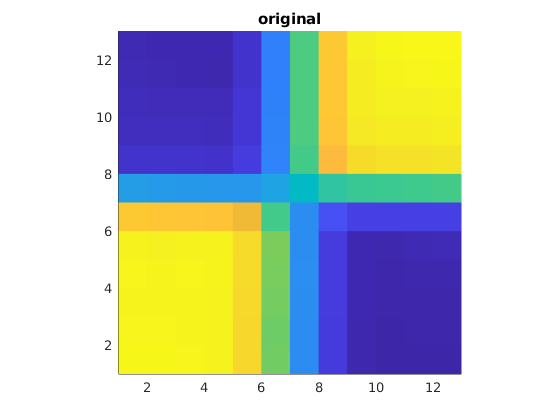

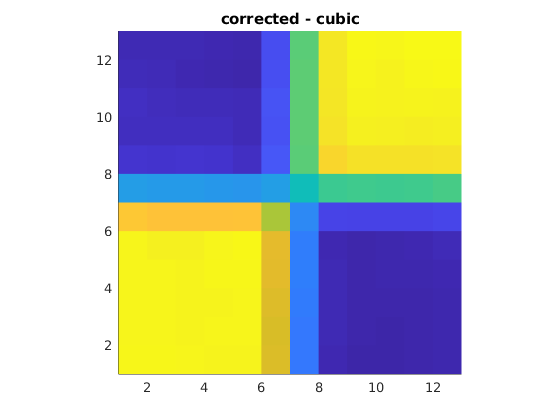

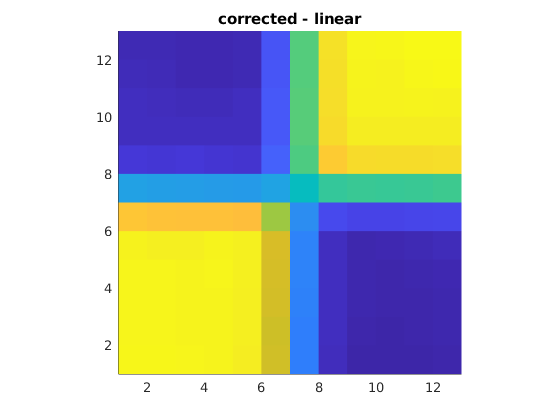

In [8]:
index_OG_x = 97:109 ;
index_OG_y = 101:113;

index_corr_x = index_OG_x - 2;
index_corr_y = index_OG_x + 2;

surf(average_corrected_HSI_linear(index_corr_x,index_corr_y),'EdgeColor','none')
axis('equal'), view([0 0 1]),title('corrected - linear')
figure
surf(average_corrected_HSI_cubic(index_corr_x,index_corr_y),'EdgeColor','none')
axis('equal'), view([0 0 1]),title('corrected - cubic')
figure
surf(average_HSI(index_OG_x,index_OG_y),'EdgeColor','none')
axis('equal'), view([0 0 1]),title('original')

It's less blurry.

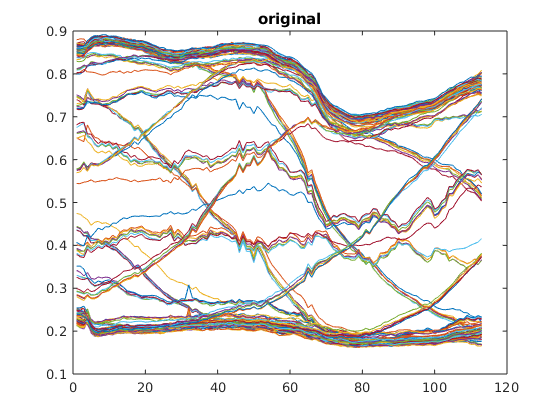

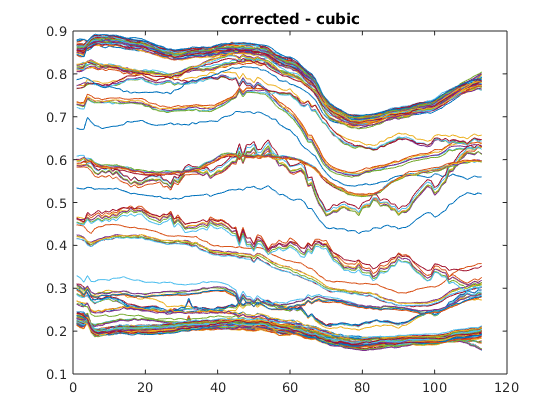

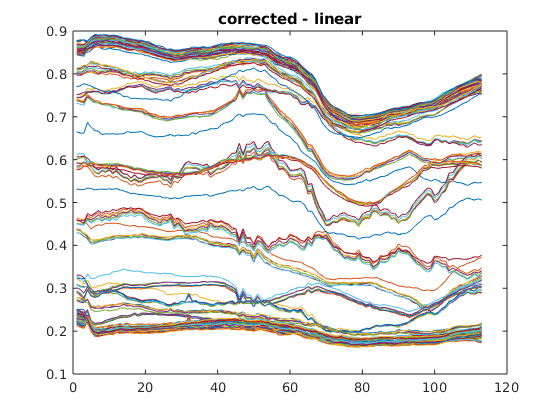

In [9]:
for i = index_corr_x
    for j = index_corr_y
        spectrum = HSI_corr_linear(i,j,:);
        plot(spectrum(:))
        hold on
    end
end
title('corrected - linear')
figure
for i = index_corr_x
    for j = index_corr_y
        spectrum = HSI_corr_cubic(i,j,:);
        plot(spectrum(:))
        hold on
    end
end
title('corrected - cubic')
figure
for i = index_OG_x
    for j = index_OG_y
        spectrum = HSI(i,j,:);
        plot(spectrum(:))
        hold on
    end
end
title('original')




## Classification and reconstruction error
The classification uses VCA, with code from J.  Bioucas-Dias, et al. "Hyperspectral unmixing overview: geometrical, statistical, and sparse regression-based approaches".

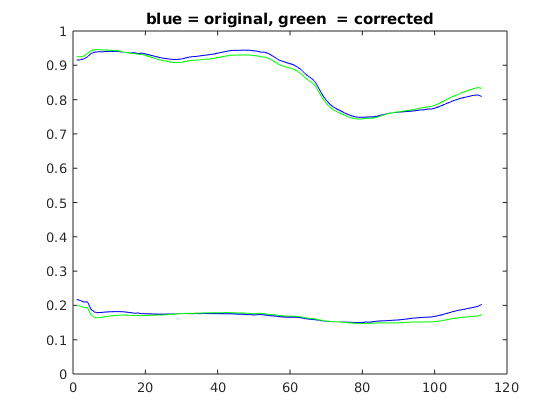

In [10]:
[HSI, lambda, nx, ny, nb] = HSI_reader('SWIR_BW_p5cm-1_corrected');

load average_path_SWIR_cubic.mat
HSI_corr = HSI_apply_pixelcorrection('SWIR_BW_p5cm-1_corrected', 50, 'cubic', average_path);

[endm_OG abund_OG] = HSI_linear_unmixing(HSI,2,300*300);
[endm_corr abund_corr] = HSI_linear_unmixing(HSI_corr,2,295*295);

plot(endm_OG,'b'), ylim([0,1])
hold on
plot(endm_corr,'g'), ylim([0,1])
title('blue = original, green  = corrected')
% sum(abund_OG) % gives ones, as it should.

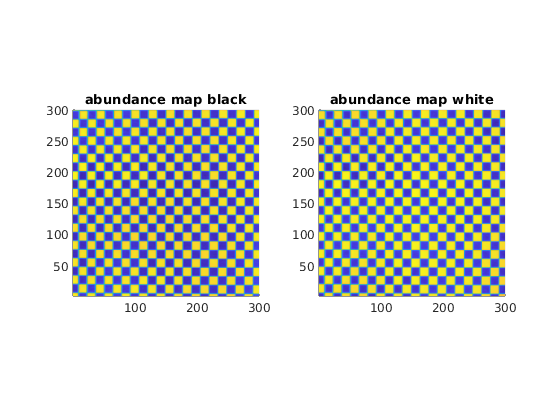

In [11]:
abundance_black = reshape(abund_OG(1,:),[300 300]);
abundance_white = reshape(abund_OG(2,:),[300 300]);
figure
subplot(121)
HSI_plot_frame(abundance_black)
title('abundance map black')
subplot(122)
HSI_plot_frame(abundance_white)
title('abundance map white')


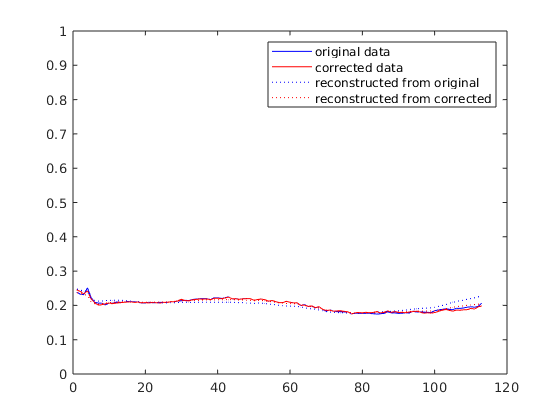

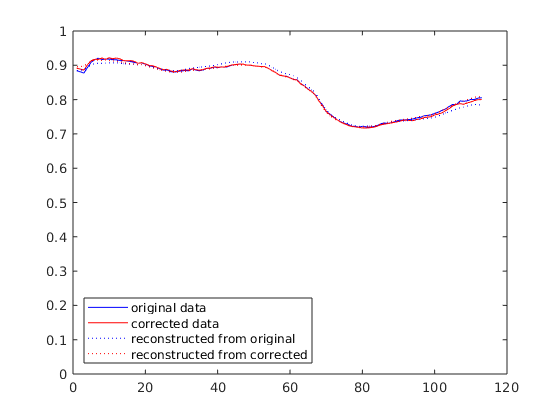

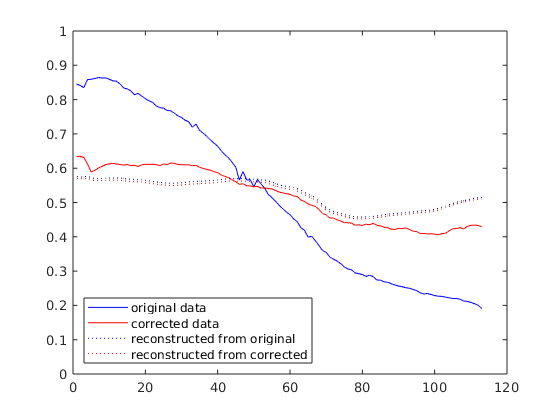

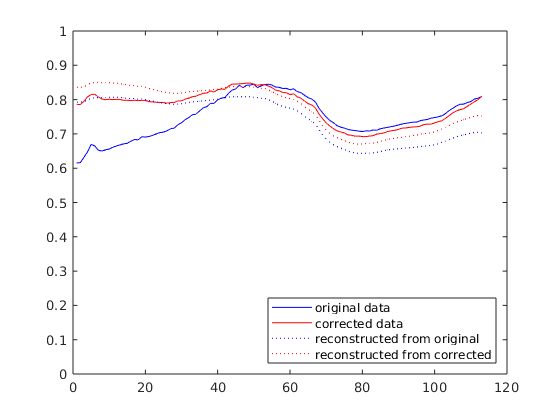

In [12]:
for i = 1:4
figure
    switch i
        case 1
            i = 11;
            j = 11;
            location = 'southeast';
        case 2
            i = 14;
            j = 23;
            location = 'southwest';
        case 3 % white
            i = 10;
            j = 18;
            location = 'southwest';
        case 4 % black
            i = 16;
            j = 3;
            location = 'northeast';
    end
    k_OG = i+300*(j-1);
    k_corr = i-2+295*(j-3); % HSI(i,j,50) == HSI+corr(i-2,j-2,50) 
    datapoint = HSI(i,j,:);
    plot(datapoint(:),'b')
    hold on
    datapoint = HSI_corr(i-2,j-2,:);
    plot(datapoint(:),'r')
    
    reconstruction = abund_OG(1,k_OG)*endm_OG(:,1) + abund_OG(2,k_OG)*endm_OG(:,2);
    plot(reconstruction,'b:'),    
    reconstruction = abund_corr(1,k_corr)*endm_corr(:,1) + abund_corr(2,k_corr)*endm_corr(:,2);
    plot(reconstruction,'r:'), ylim([0,1])
    
    legend('original data','corrected data','reconstructed from original','reconstructed from corrected','location',location)
%    plot([50 50],[0 1])
    hold off
end


**Error map**

Reconstruction error map and (weighted) reconstruction error sum

average_error_corrected =
    0.1638
average_error_original =
    0.4712
ratio =
    2.8757


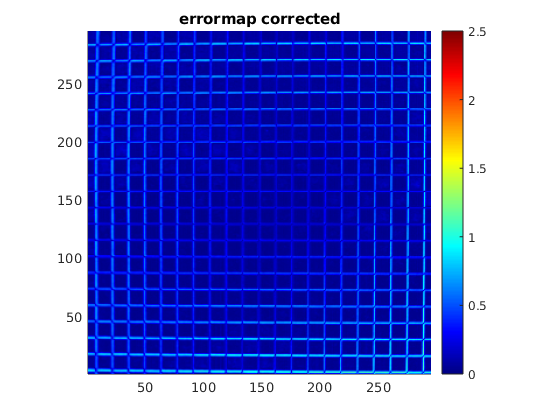

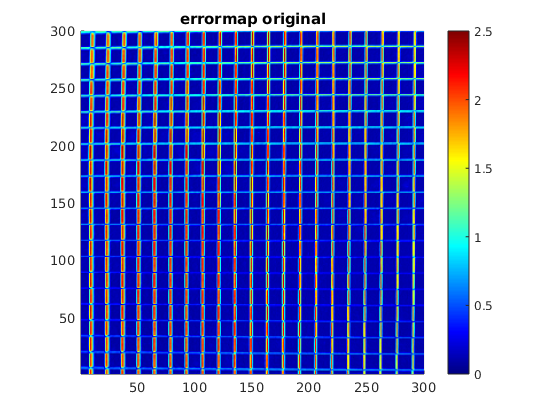

In [13]:
%plot inline

err = endm_OG*abund_OG - reshape(HSI, [300*300 113])';
error_map = vecnorm(err);
HSI_plot_frame(reshape(error_map,[300, 300]))
colormap jet
caxis([0 2.5])
colorbar
average_error_original = mean(error_map);
title('errormap original')

figure

err = endm_corr*abund_corr - reshape(HSI_corr, [295*295 113])';
error_map = vecnorm(err);
HSI_plot_frame(reshape(error_map,[295, 295]))
colormap jet
caxis([0 2.5])
colorbar
title('errormap corrected')

average_error_corrected = mean(error_map)
average_error_original
ratio = average_error_original/average_error_corrected

Note thate the error in the original is bigger on the right side. The ratio of 2.9 might seem lower as expected, the border is only a fraction of the image.
* Only black ink works in infrared -- manual: 

# Correction of the wavelength dependent pixel drift  - VNIR
We'll do the same thing with the VNIR; and actualy do some unmixing (cyan-magenta-yellow are invisible in IR, so unmixing couldn't be done on printed paper).

## Analysing the pixel drift
### Estimeating the pixel drift with a checker board

In [14]:
do_calculation = true;
do_calculation = false  % calculation may take a while, comment this line to do calculation


if do_calculation
    for interp_method = ["linear","cubic"]
        interp_method
        tic
        total_path = './metingen/project pixelmovement/VNIR/VNIR_BW_*_corrected.raw';
        names = find_files(total_path);
        [~,n] = size(names);
        all_paths = {};
        for i = 1:n
           i
           r = HSI_pathfinder(names{i}, 75, interp_method, 2); %todo: reference pixel and wavelength in file
           all_paths{end+1} = r;
        end
        toc
        if interp_method == "linear"
            save all_paths_VNIR_linear.mat all_paths
        else
            save all_paths_VNIR_cubic.mat all_paths         
        end
    end
else
    load all_paths_VNIR_linear.mat
    load all_paths_VNIR_cubic.mat
end


do_calculation =
  logical
   0


In time we took

 * Linear:   2491 seconds. (40 min)
 * Cubic:    3263 seconds  (54 min)

All paths plotted gives

interp_method = 
    "linear"
maximum_deviation =
    0.3186
interp_method = 
    "cubic"
maximum_deviation =
    0.5220


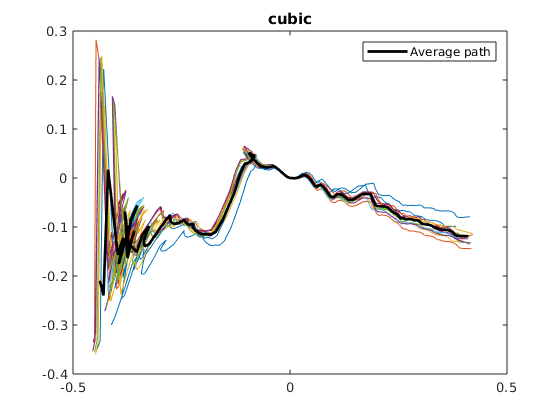

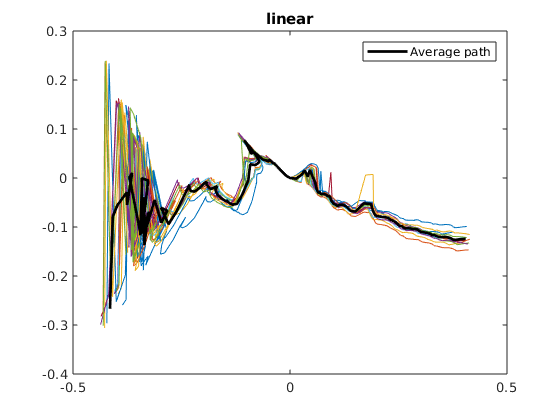

In [15]:
for interp_method = ["linear","cubic"]
    if interp_method == "linear"
        load all_paths_VNIR_linear.mat
    else
        load all_paths_VNIR_cubic.mat
    end
    
    [~,n] = size(all_paths);
    average_path = zeros(size(all_paths{1}));
    figure
    for i = 1:n
        r = all_paths{i};
        plot(r(1,:),r(2,:),'HandleVisibility','off')
        hold on
        average_path = average_path +r;
    end
    average_path =  average_path/n;
    plot(average_path(1,:),average_path(2,:),'k','linewidth',2)
    [~, nb] = size(average_path);
    legend('Average path')
    title(interp_method)
    maximum_deviation = 0;
    for i = 1:n
        r = all_paths{i};
        deviation = r-average_path;
        for j = 1:nb
            if norm(deviation(:,j)) > maximum_deviation
                maximum_deviation = norm(deviation(:,j));
            end
        end
    end
    interp_method
    maximum_deviation
    
    if interp_method == "linear"
        save average_path_VNIR_linear average_path
    else
        save average_path_VNIR_cubic average_path
    end 
end

% maximum_deviation_in_pixels = maximum_deviation
% maximum_deviation_in_cm = maximum_deviation_in_pixels *0.0087

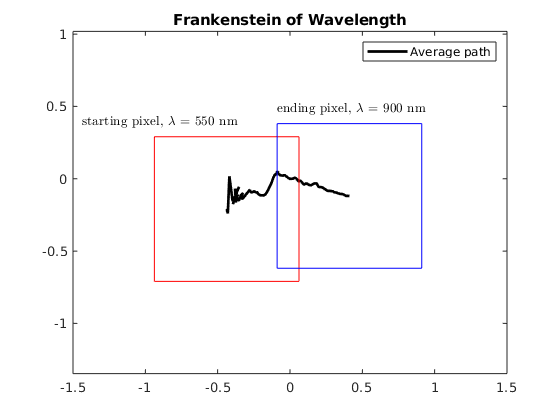

In [16]:
[HSI, lambda, nx, ny, nb] = HSI_reader('VNIR_BW_p5cm-1_corrected');


load average_path_VNIR_linear.mat

HSI_corr_linear = HSI_apply_pixelcorrection('VNIR_BW_p5cm-1_corrected', 50, 'linear', average_path);
subplot(132)
average_corrected_HSI_linear = HSI_wavelength_average(HSI_corr_linear);
surf(average_corrected_HSI_linear,'EdgeColor','none')
axis('equal'), view([0 0 1.1])
title('corrected - linear')
sum(isnan(HSI_corr_linear(:)))

% cubic
load average_path_SWIR_cubic.mat
HSI_corr_cubic = HSI_apply_pixelcorrection('SWIR_BW_p5cm-1_corrected', 50, 'linear', average_path);
subplot(133)
average_corrected_HSI_cubic = HSI_wavelength_average(HSI_corr_cubic);
surf(average_corrected_HSI_cubic,'EdgeColor','none')
axis('equal'), view([0 0 1.1])
title('corrected - cubic')
sum(isnan(HSI_corr_cubic(:)))
plot(average_path(1,:),average_path(2,:),'k','linewidth',2)
[~, nb] = size(average_path);
title('Frankenstein of Wavelength'), axis([-1.5,1.5,-1, 1])
legend('Average path')
axis equal, hold on

% draw_pixel(0,0,'g')
% text(-.5,.6,'reference pixel, $\lambda$  = 1337nm','interpreter', 'latex')

draw_pixel(average_path(1,1),average_path(2,1),'r')
text(average_path(1,1)-1,average_path(2,1) + .6,'starting pixel, $\lambda$  = 550 nm','interpreter', 'latex')

draw_pixel(average_path(1,end),average_path(2,end),'b')
text(average_path(1,end)-.5,average_path(2,end) + .6,'ending pixel, $\lambda$  = 900 nm','interpreter', 'latex')


The starting bands seem realy noisy so we will take fewer bands to do the unmixing.

start_band =
    28
interp_method = 
    "linear"
maximum_deviation =
    0.0797
interp_method = 
    "cubic"
maximum_deviation =
    0.0460


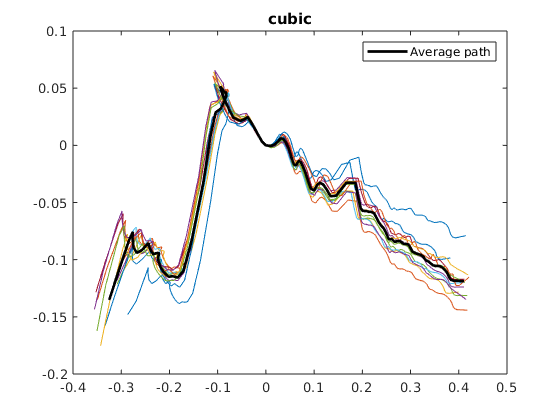

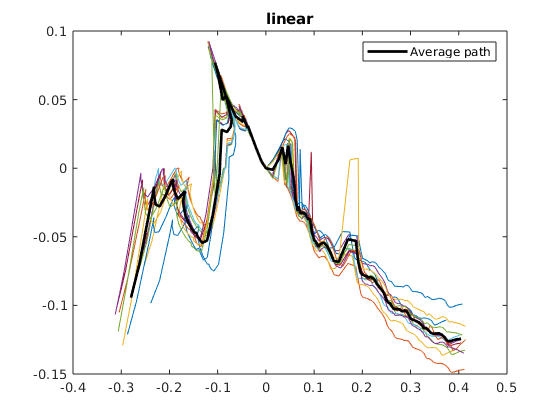

In [17]:
start_band = 28

and store in dark conditions.
for interp_method = ["linear","cubic"]
    figure
    if interp_method == "linear"
        load all_paths_VNIR_linear.mat
        load average_path_VNIR_linear average_path
    else
        load all_paths_VNIR_cubic.mat
        load average_path_VNIR_cubic average_path
    end
    
    for i = 1:n
        r = all_paths{i};
        plot(r(1,start_band:end),r(2,start_band:end),'HandleVisibility','off')
        hold on
    end

    plot(average_path(1,start_band:end),average_path(2,start_band:end),'k','linewidth',2)
    [~, nb] = size(average_path);
    legend('Average path')
    title(interp_method)
    
    maximum_deviation = 0;
    for i = 1:n
        r = all_paths{i};
        deviation = r-average_path;
        for j = start_band:nb
            if norm(deviation(:,j)) > maximum_deviation
                maximum_deviation = norm(deviation(:,j));
            end
        end
    end
    interp_method
    maximum_deviation
end

% maximum_deviation_in_pixels = maximum_deviation
% maximum_deviation_in_cm = maximum_deviation_in_pixels *0.0087


the maximum deviation changed from 0.52 to 0.04 pixel for cubic interpolation if we start at the 28 band

In [18]:
length_path_pixel = norm(average_path(:,1)-average_path(:,end))
length_path_cm = length_path_pixel *  0.0087

length_path_pixel =
    0.8535
length_path_cm =
    0.0074


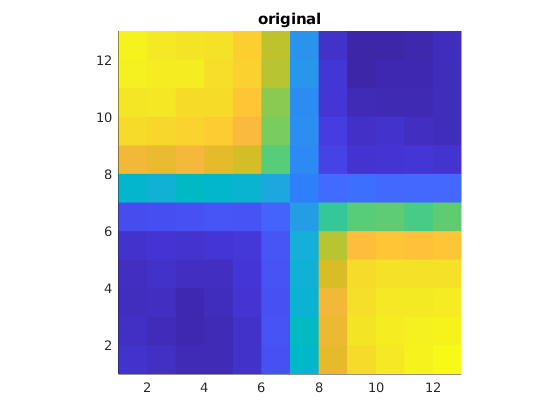

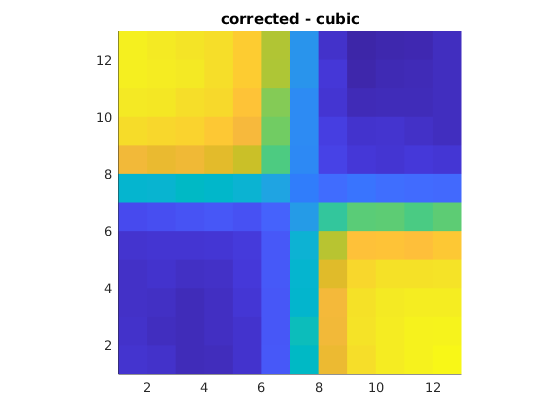

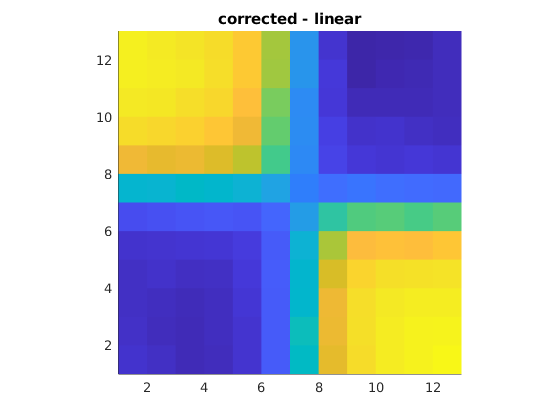

In [69]:
[HSI, lambda, nx, ny, nb] = HSI_reader('VNIR_BW_p25cm-1_corrected');

% % % correct

load average_path_VNIR_linear.mat
HSI_corr_linear = HSI_apply_pixelcorrection('VNIR_BW_p25cm-1_corrected', 75, 'linear', average_path);

load average_path_VNIR_cubic.mat
HSI_corr_cubic = HSI_apply_pixelcorrection('VNIR_BW_p25cm-1_corrected', 75, 'cubic', average_path);

% % reduce

HSI_corr_linear(:,:,1:27) = []; 
HSI_corr_cubic(:,:,1:27) = [];

% % find pixel difference
% % di = -1
% % dj = -1
% % HSI(i,j,75)-HSI_corr_cubic(i+di,j+dj,75-27);

index_OG_x = 118:130;
index_OG_y = 107:119;

index_corr_x = index_OG_x - 1;
index_corr_y = index_OG_y - 1;


average_HSI = HSI_wavelength_average(HSI_corr_linear);
HSI_plot_frame(average_HSI(index_corr_x,index_corr_y))
title('corrected - linear')

figure

average_HSI = HSI_wavelength_average(HSI_corr_cubic);
HSI_plot_frame(average_HSI(index_corr_x,index_corr_y))
title('corrected - cubic')

figure

average_HSI = HSI_wavelength_average(HSI);
HSI_plot_frame(average_HSI(index_OG_x,index_OG_y))
title('original')

No significant difference

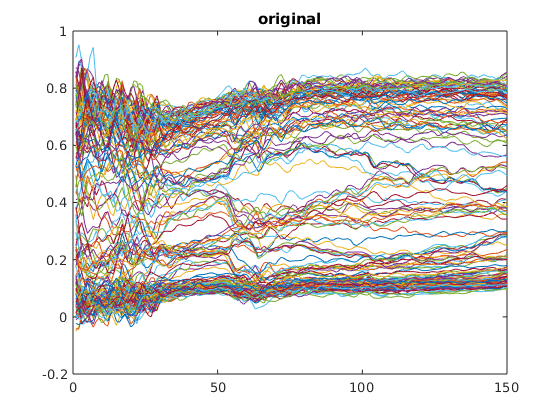

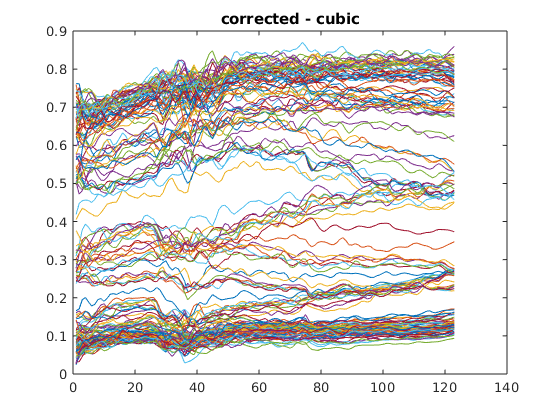

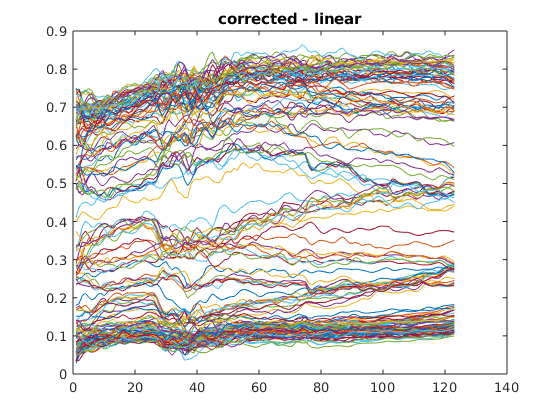

In [70]:
for i = index_corr_x
    for j = index_corr_y
        spectrum = HSI_corr_linear(i,j,:);
        plot(spectrum(:))
        hold on
    end
end
title('corrected - linear')
figure
for i = index_corr_x
    for j = index_corr_y
        spectrum = HSI_corr_cubic(i,j,:);
        plot(spectrum(:))
        hold on
    end
end
title('corrected - cubic')
figure
for i = index_OG_x
    for j = index_OG_y
        spectrum = HSI(i,j,:);
        plot(spectrum(:))
        hold on
    end
end
title('original')



## Unmixing 5 endmember checkerboard
We now try to unmix a checkerboard which looks like
<img src="images/color2.png">
with endmembers black white, cyan, mangenta, yellow (and gray, as a linear combination of black and white)


|   |       |         |          |       |
|---|-------|---------|----------|-------|
|   | white | magenta | yellow   | gray  |
|   | cyan  | black   | magenta | white |

This been done with a sidelength of both 0.25 and 0.125 $cm$.

### Unmixing a multicolor checkerboard

ans =
    0.7739    0.2219    0.3133


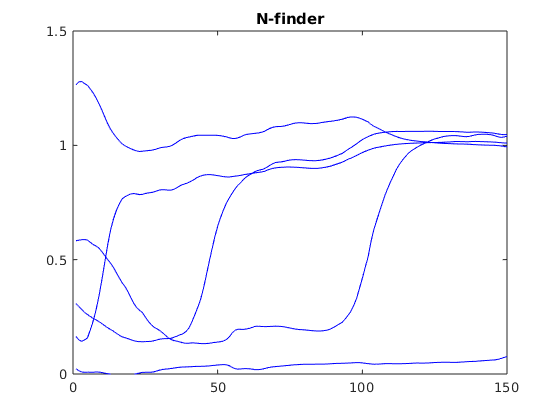

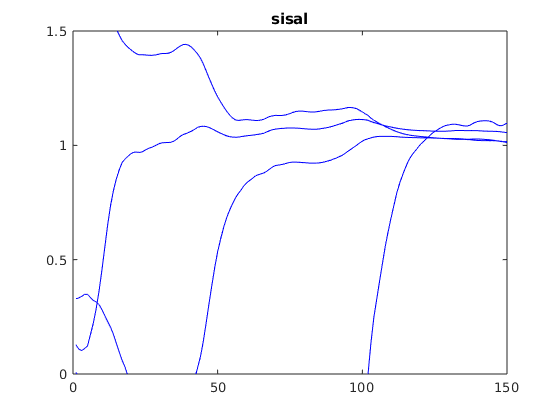

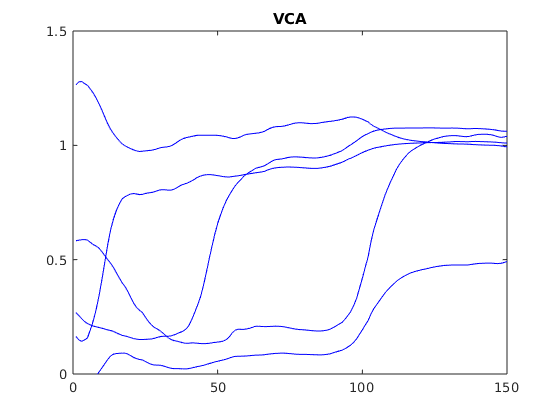

In [140]:
[HSI, lambda, nx, ny, nb] = HSI_reader('VNIR_color2_p25-1_corrected.raw');

[E_VCA_OG, A_VCA_OG, E_sisal_OG, A_sisal_OG, E_NF_OG, A_NF_OG] = HSI_linear_unmixing(HSI,5,'all');

% VCA
plot(E_VCA_OG,'b'), ylim([0,1.5])
title('VCA')
err = E_VCA_OG*A_VCA_OG - reshape(HSI, [nx*ny nb])';

error_map = vecnorm(err);
average_error_VCA = mean(error_map);

% sisal
figure
plot(E_sisal_OG,'b'), ylim([0,1.5])
title('sisal')
err = E_sisal_OG*A_sisal_OG - reshape(HSI, [nx*ny nb])';
error_map = vecnorm(err);
average_error_sisal = mean(error_map);

% N-finder
figure
plot(E_NF_OG,'b'), ylim([0,1.5])
title('N-finder')
err = E_NF_OG*A_NF_OG - reshape(HSI, [nx*ny nb])';
error_map = vecnorm(err);
average_error_NF = mean(error_map);

[average_error_VCA average_error_sisal average_error_NF]

Please note that the endmembers are verry different and exceed 1 (maximum value of the HSI is 1.5). Sisal has negative 

why?

Now let's work with the *reduced bandwith data*, and the *reduced and corrected data*.

**correcting the data**

ans =
     0


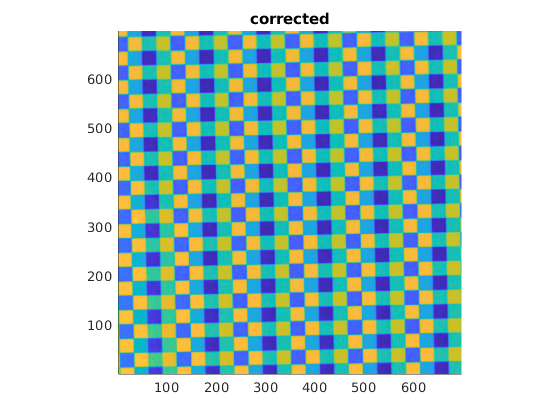

In [141]:
load average_path_VNIR_cubic.mat
HSI_corr = HSI_apply_pixelcorrection('VNIR_color2_p25-1_corrected.raw', 75, 'cubic', average_path);
% subplot(133)
average_corrected_HSI = HSI_wavelength_average(HSI_corr);
surf(average_corrected_HSI','EdgeColor','none')
axis('equal'), view([0 0 1.1])
title('corrected')
sum(isnan(HSI_corr(:)))

**reduce the data** -- take away band `1:27` and leave `28:end`.

In [142]:
hsi = HSI;
hsi(:,:,1:27) = []; 

hsi_corr = HSI_corr;
hsi_corr(:,:,1:27) = [];

Unimix the reduced uncorreted data

ans =
    0.2252    0.1233    0.1956


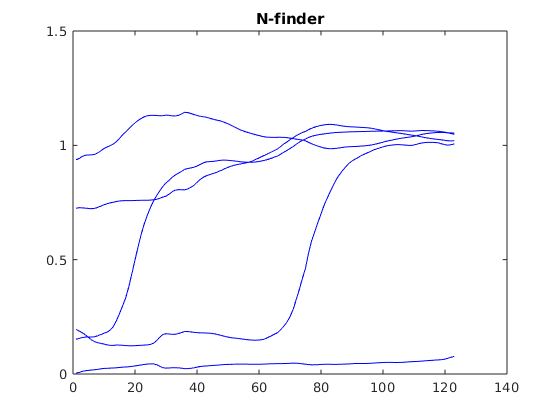

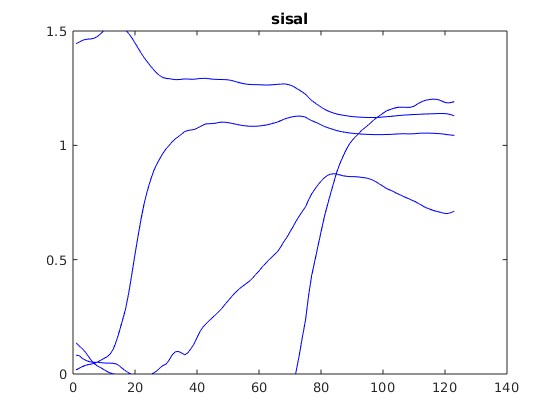

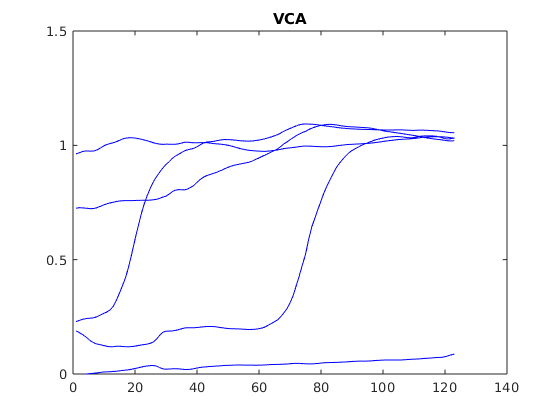

In [143]:
[nx, ny, nb] = size(hsi);
[E_VCA_og, A_VCA_og, E_sisal_og, A_sisal_og, E_NF_og, A_NF_og] = HSI_linear_unmixing(hsi,5,'all');

% VCA
plot(E_VCA_og,'b'), ylim([0,1.5])
title('VCA')
err = E_VCA_og*A_VCA_og - reshape(hsi, [nx*ny nb])';

error_map = vecnorm(err);
average_error_VCA = mean(error_map);

% sisal
figure
plot(E_sisal_og,'b'), ylim([0,1.5])
title('sisal')
err = E_sisal_og*A_sisal_og - reshape(hsi, [nx*ny nb])';
error_map = vecnorm(err);
average_error_sisal = mean(error_map);

% N-finder
figure
plot(E_NF_og,'b'), ylim([0,1.5])
title('N-finder')
err = E_NF_og*A_NF_og - reshape(hsi, [nx*ny nb])';
error_map = vecnorm(err);
average_error_NF = mean(error_map);

[average_error_VCA average_error_sisal average_error_NF]

We choose VCA for not being negative. Which leads to the abundance maps:

ans =
    0.6044    0.1140    0.2208


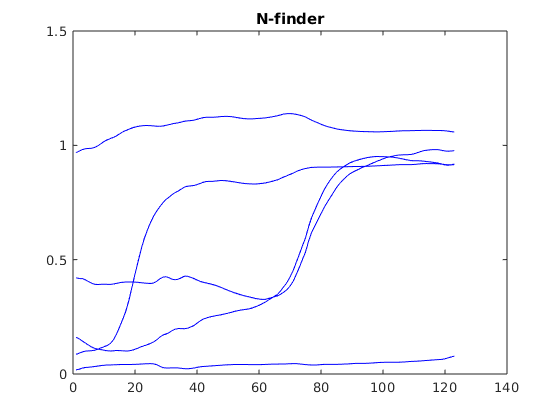

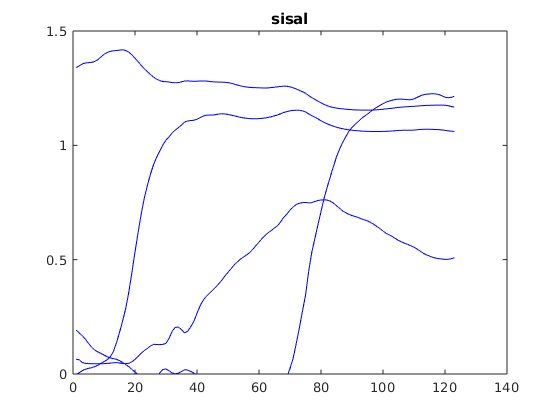

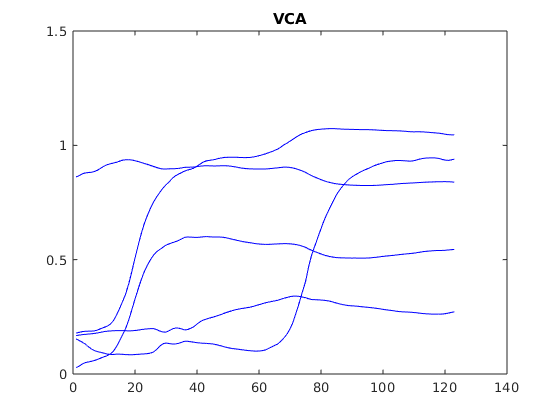

In [144]:
[nx, ny, nb] = size(hsi_corr);
[E_VCA_corr, A_VCA_corr, E_sisal_corr, A_sisal_corr, E_NF_corr, A_NF_corr] = HSI_linear_unmixing(hsi_corr,5,'all');

% VCA
plot(E_VCA_corr,'b'), ylim([0,1.5])
title('VCA')
err = E_VCA_corr*A_VCA_corr - reshape(hsi_corr, [nx*ny nb])';

error_map = vecnorm(err);
average_error_VCA = mean(error_map);

% sisal
figure
plot(E_sisal_corr,'b'), ylim([0,1.5])
title('sisal')
err = E_sisal_corr*A_sisal_corr - reshape(hsi_corr, [nx*ny nb])';
error_map = vecnorm(err);
average_error_sisal = mean(error_map);

% N-finder
figure
plot(E_NF_corr,'b'), ylim([0,1.5])
title('N-finder')
err = E_NF_corr*A_NF_corr - reshape(hsi_corr, [nx*ny nb])';
error_map = vecnorm(err);
average_error_NF = mean(error_map);

[average_error_VCA average_error_sisal average_error_NF]

In [76]:
% inspect the HSI
cwd = pwd
cd './metingen/project pixelmovement/VNIR'
HSI_Palpator
cd(cwd)

cwd =
    '/home/tim/Dropbox/Master Thesis/Project Pixel Drift'


let's compare the methods in error maps

ans =
    'original'
average_error_original =
    0.7739
ans =
    'corrected'
average_error_original =
    0.6044


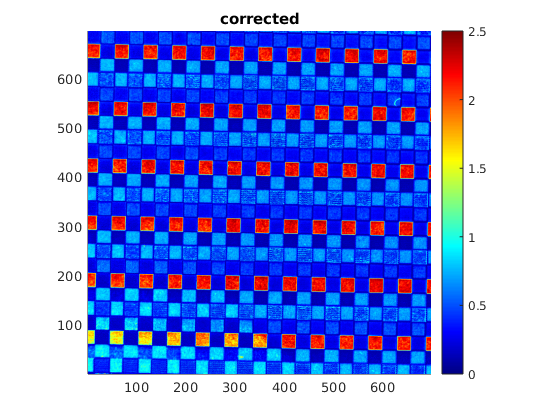

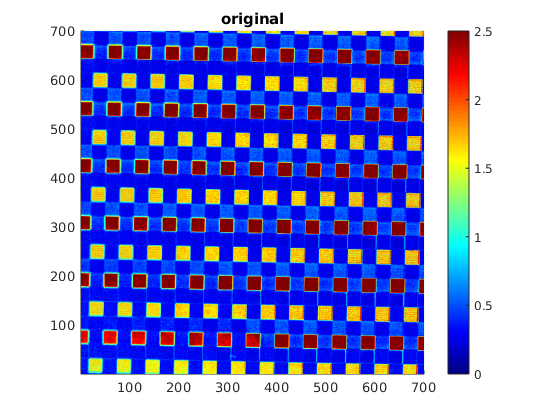

In [145]:
[nx,ny,nb] = size(HSI);
err = E_VCA_OG *A_VCA_OG - reshape(HSI, [nx*ny, nb])';
error_map = vecnorm(err);
HSI_plot_frame(reshape(error_map,[nx, ny]))
colormap jet
caxis([0 2.5])
colorbar
'original'
average_error_original = mean(error_map)
title('original')


figure

[nx,ny,nb] = size(hsi_corr);
err = E_VCA_corr* A_VCA_corr - reshape(hsi_corr, [nx*ny, nb])';
error_map = vecnorm(err);
HSI_plot_frame(reshape(error_map,[nx, ny]))
colormap jet
caxis([0 2.5])
colorbar
title('corrected')
'corrected'
average_error_original = mean(error_map)



**Comparing the 3 methods**

The unmixing methods use stochastical methods and give varying results. On average $\pm$ standard devition we get:

We now try to unmix a checkerboard which looks like
<img src="images/bar.png">


| reconstruction error             | VCA ($\times$100)| sisal ($\times$1)|N-finder ($\times$100)|       
|----------------------------------|-----|-------|----------|
| Original                         | 0.47 $\pm$ 0.24    |   0.2219  | 0.316 $\pm$ 0.018 |       
| Pixeldrift corrected            |    0.332 $\pm$ 0.088  |    0.1921    | 0.2826  $\pm$ 0.0022  |  
| Original reduced                |  0.27  $\pm$  0.10  |     0.1205   |   0.35  $\pm$ 0.15  | 
| Pixeldrift corrected and reduced| 0.263   $\pm$ 0.090 |   0.1123     | 0.28  $\pm$  0.14  |  


    


<!---
your comment goes here
and here

| reconstruction error             | VCA | sisal | N-finder |       
|----------------------------------|-----|-------|----------|
| Original                         |    0.3564    |0.2219    |0.3133|
|  Original reduced                | 0.4815    |0.1233    |0.4740|
| Pixeldrift corrected and reduced |  0.1848    |0.1140    |0.2475|




I repeated this experiment with three other sameples (offscreen)

**same sample rotated 45°** ('VNIR_color2_p25-2h_corrected.raw')

| reconstruction error             | VCA | sisal | N-finder |       
|----------------------------------|-----|-------|----------|
| Original                         |  0.6714     |  0.2165     | 0.2847         |              
|  Original reduced                |    0.5026             | 0.1217        |  0.2608      | 
| Pixeldrift corrected and reduced |  0.1991         | 0.1122          | 0.5611       |     

| reconstruction error             | VCA | sisal | N-finder |       
|----------------------------------|-----|-------|----------|
| Original                        |0.2774   | 0.2165  |  0.2847 |
| Original reduced                | 0.3730  |  0.1216  |  0.5125 |
|Pixeldrift corrected and reduced | 0.6996  |  0.1122  |  0.5579 |


    

**sample square half the side (.125 cm)** ('VNIR_color2_p125-1_corrected.raw')

| reconstruction error             | VCA | sisal | N-finder |       
|----------------------------------|-----|-------|----------|
| Original                        | 0.3131  |  0.2272   | 0.3010|
| Original reduced                | 0.2268 |   0.1295 |   0.4418|
|Pixeldrift corrected and reduced |  0.2406   | 0.1182   |0.2776|

| reconstruction error             | VCA | sisal | N-finder |       
|----------------------------------|-----|-------|----------|
| Original                        |0.2894    |0.2272    |0.3010|
| Original reduced                | 0.3224    |0.1295    |0.2101|
|Pixeldrift corrected and reduced | 0.1830    |0.1182    |0.2703|


**sample square half the side rotated 45° (.125 cm)** ('VNIR_color2_p125-2h_corrected.raw')

| reconstruction error             | VCA | sisal | N-finder |       
|----------------------------------|-----|-------|----------|
| Original                        | 0.3689    |0.2237    |0.5793|
| Original reduced                | 0.1796    |0.1288    |0.4447|
|Pixeldrift corrected and reduced | 0.6876    |0.1184    |0.2324|




| reconstruction error             | VCA | sisal | N-finder |       
|----------------------------------|-----|-------|----------|
| Original                        |0.5625    |0.2237    |0.6151|
| Original reduced                | 0.3816    |0.1288    |0.2707|
|Pixeldrift corrected and reduced | 0.2754    |0.1184    |0.4702|
-->

**Conclusion**
Improves Sisal, but has barly effect on N-finder and VCA. 

*It isn't a magic bullet*.
    
    
### endmember analysis
**White**


dataset =
     1


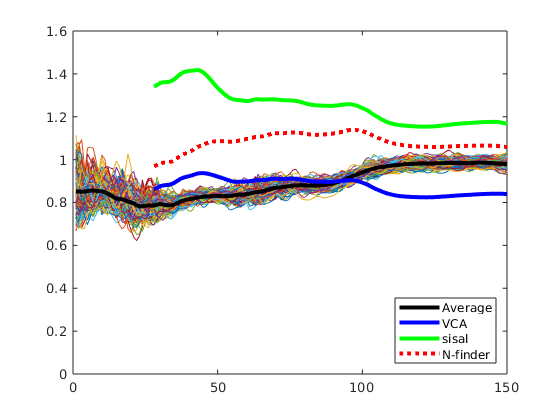

In [150]:
load('white.mat')
plot(collected_spectra,'HandleVisibility','off'), ylim([0, 1.6])
hold on
gem = mean(collected_spectra');
plot(gem','k','LineWidth',3)
dataset = 1
switch dataset
    case 1
        plot(28:150,E_VCA_corr(:,1),'b','LineWidth',3)
        plot(28:150,E_sisal_corr(:,1),'g','LineWidth',3)
        plot(28:150,E_NF_corr(:,4),':r','LineWidth',3)
    case 2
        plot(28:150,E_VCA_og(:,1),'b','LineWidth',3)
        plot(28:150,E_sisal_og(:,1),'g','LineWidth',3)
        plot(28:150,E_NF_og(:,2),':r','LineWidth',3)
    case 3
        plot(E_VCA_OG(:,1),'b','LineWidth',3)
        plot(E_sisal_OG(:,1),'g','LineWidth',3)
        plot(E_NF_OG(:,2),':r','LineWidth',3)
end
legend('Average','VCA','sisal','N-finder','location','southeast')



? Why so bad ?

**Black**

dataset =
     1


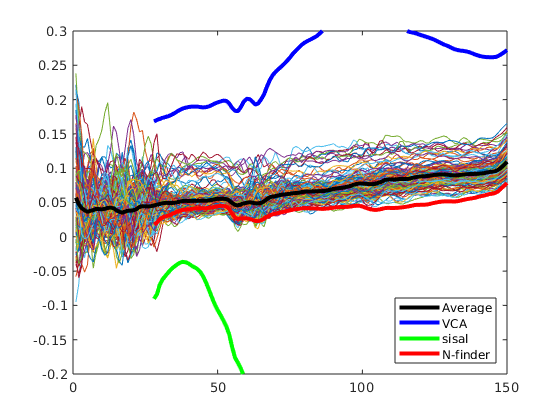

In [166]:
load black
figure

plot(collected_spectra,'HandleVisibility','off'), ylim([0 .5])
hold on
gem = mean(collected_spectra');
plot(gem','k','LineWidth',3)

dataset = 1
switch dataset
    case 1
        plot(28:150,E_VCA_corr(:,5),'b','LineWidth',3)
        plot(28:150,E_sisal_corr(:,2),'g','LineWidth',3), ylim([-.2 .3])
        plot(28:150,E_NF_corr(:,1),'r','LineWidth',3)
    case 2
        plot(28:150,E_VCA_og(:,2),'b','LineWidth',3)
        plot(28:150,E_sisal_og(:,4),'g','LineWidth',3), ylim([-.2 .3])
        plot(28:150,E_NF_og(:,2),':r','LineWidth',3)
end
legend('Average','VCA','sisal','N-finder','location','southeast')

**Magenta**

dataset =
     1


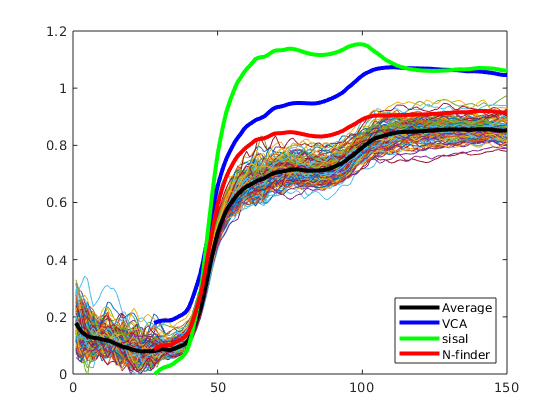

In [168]:
load magenta
figure
plot(collected_spectra,'HandleVisibility','off')
hold on
gem = mean(collected_spectra');
plot(gem','k','LineWidth',3)

dataset = 1
switch dataset
    case 1
        plot(28:150,E_VCA_corr(:,4),'b','LineWidth',3)
        plot(28:150,E_sisal_corr(:,3),'g','LineWidth',3),
        plot(28:150,E_NF_corr(:,5),'r','LineWidth',3)
        ylim([0 1.2])
end
legend('Average','VCA','sisal','N-finder','location','southeast')

**Cyan**

dataset =
     1


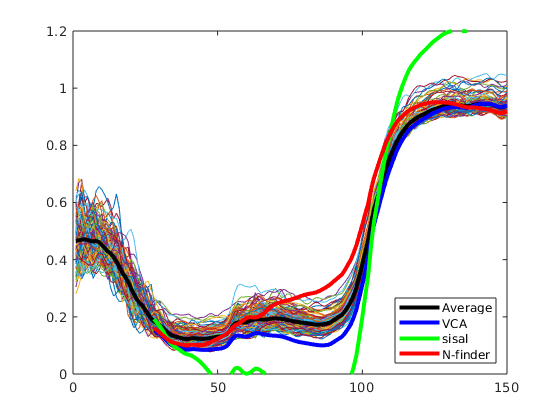

In [170]:
load cyan
figure
plot(collected_spectra,'HandleVisibility','off')
hold on
gem = mean(collected_spectra');
plot(gem','k','LineWidth',3)

dataset = 1
switch dataset
    case 1
        plot(28:150,E_VCA_corr(:,3),'b','LineWidth',3)
        plot(28:150,E_sisal_corr(:,4),'g','LineWidth',3),
        plot(28:150,E_NF_corr(:,2),'r','LineWidth',3)
        ylim([0 1.2])
end
legend('Average','VCA','sisal','N-finder','location','southeast')

**Yellow**


dataset =
     1


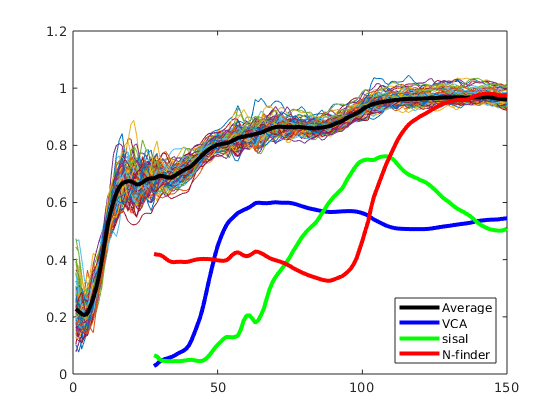

In [171]:
load yellow % wavelength; 570, cuttof is 550nm...
figure
plot(collected_spectra,'HandleVisibility','off')
hold on
gem = mean(collected_spectra');
plot(gem','k','LineWidth',3)

dataset = 1
switch dataset
    case 1
        plot(28:150,E_VCA_corr(:,2),'b','LineWidth',3) %only one left
        plot(28:150,E_sisal_corr(:,5),'g','LineWidth',3),
        plot(28:150,E_NF_corr(:,3),'r','LineWidth',3)
        ylim([0 1.2])
    case 3
        plot(E_VCA_OG(:,4),'b','LineWidth',3)
        plot(E_sisal_OG(:,2),'g','LineWidth',3)
        plot(E_NF_OG(:,5),':r','LineWidth',3)
end
legend('Average','VCA','sisal','N-finder','location','southeast')

*Cutting off the wavelength is not good for business, if business is identifying yellow*
### Abundance map

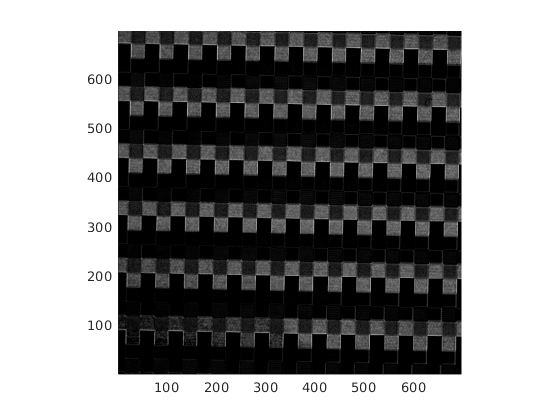

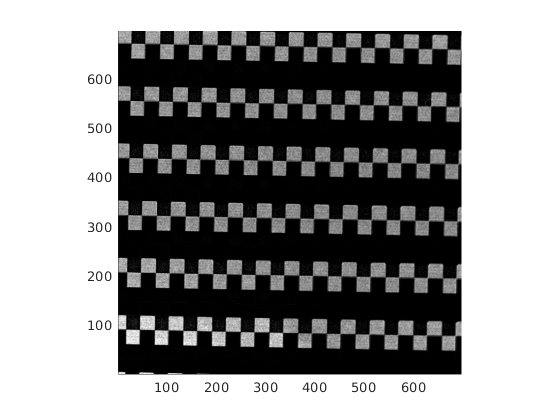

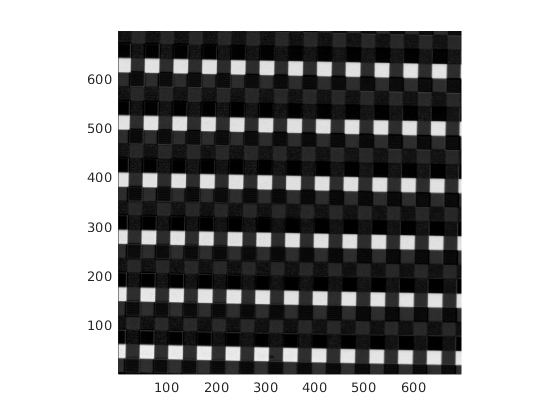

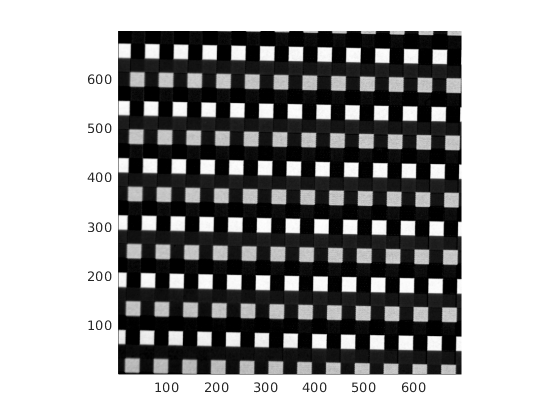

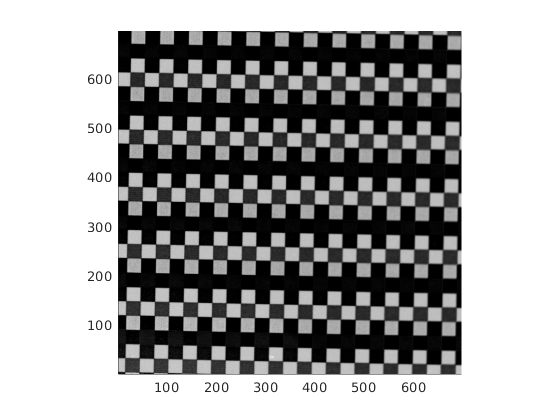

In [85]:
% [endm_VCA_corr_red, abund_VCA_corr_red, endm_sisal_corr_red, abund_sisal_corr_red]
abund = A_VCA_corr;
endm = E_VCA_corr;

for i = 1:5
    figure
    abundance_endm = reshape(abund(i,:),[697   697]);
    HSI_plot_frame(abundance_endm)
    colormap gray
end

# Conclusion
## SWIR

* Pixeldrift siginificant (ength_path_pixel = 2.5 pixels,  0.09 cm  ~ 1 mm)
* Pixelcorrection improves the data measurably (but not perfectly)
* blurring inevitable
* cubic interpolation gives best results (for a checkerboard type image).

## VNIR

* short wavelength (470-548 $nm$) verry unreliable.
* Pixeldrift far less important (0.8 pixel, 0.007 cm ~  0.1 mm)  --   *order of magnitude smaller*
* Unmixing needs te be finetuned (better algorithms?)

### Further investigation
* other unmixing methods?
* downsampling?
* rewrite code in OOP

### Remarks
* pixelnoise is correlated when applying corections
* chromatic aberation???

# to do
1. downsampling
2. measure spectrum via spectrograph
3. chromatic aberation???
3. black hole radiation + IR absorbtion 
4. check white and dark? Do correction?
5. update toggle


* Make reddit new (matlab, pythom, remote, datascience, xckd)